In [1]:




from common import GENRES
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model
from keras import models
from keras import layers
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Dropout, Activation, \
        TimeDistributed, Convolution1D, MaxPooling1D, BatchNormalization
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from optparse import OptionParser
from sys import stderr, argv
import os

SEED = 42
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 256
BATCH_SIZE = 32
EPOCH_COUNT = 500
MODEL_PATH=""
TRACK_PATH=""




import sys; sys.argv=['']; del sys








Using TensorFlow backend.


In [2]:
from keras.callbacks import TensorBoard
import os
path="./"

tensorboard_path=os.path.join(path,"tensorboard")
os.makedirs(tensorboard_path, exist_ok=True)
tb = TensorBoard(log_dir=tensorboard_path)

In [3]:
def train_model(data, model_path):
    x = data['x']
    y = data['y']
    (x_train, x_val, y_train, y_val) = train_test_split(x, y, test_size=0.3,
            random_state=SEED)
    #700 647 128
    print("X",x_train.shape)
    print(y_train.shape)
    print('Building model...',x_train.shape[0],x_train.shape[1],x_train.shape[2])
    model = models.Sequential()
    model.add(layers.Dense(512, activation='relu', input_shape=(647,128)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='softmax'))

    opt = Adam(lr=0.001)
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    print(model.summary())
    print('Training...')
    model.fit(
        x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
        validation_data=(x_val, y_val), verbose=1, callbacks=[
            ModelCheckpoint(
                model_path, save_best_only=True, monitor='val_acc', verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
        ]
    )


    return model



In [4]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt


from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras import regularizers
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation

num_classes = 10


N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
EPOCH_COUNT = 500
NUM_HIDDEN = 64
L2_regularization = 0.001


In [5]:
def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input

    ### 3 1D Convolution Layers
    for i in range(N_LAYERS):
        # give name to the layers
        layer = Conv1D(
                filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization),  # Tried 0.001
                name='convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.4)(layer)

    ## LSTM Layer
    layer = LSTM(LSTM_COUNT, return_sequences=False)(layer)
    layer = Dropout(0.4)(layer)

    ## Dense Layer
    layer = Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
    layer = Dropout(0.4)(layer)

    ## Softmax Output
    layer = Dense(num_classes)(layer)
    layer = Activation('softmax', name='output_realtime')(layer)
    model_output = layer
    model = Model(model_input, model_output)


    opt = Adam(lr=0.001)
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )

    print(model.summary())
    return model



In [6]:

def train_model2(data, model_path):
    x = data['x']
    y = data['y']
    (x_train, x_val, y_train, y_val) = train_test_split(x, y, test_size=0.3,random_state=SEED)
    n_features = x_train.shape[2]
    input_shape = (None, n_features)
    print("X",x_train.shape)
    print("Y ",y_train.shape)

    model_input = Input(input_shape, name='input')
    print("Test 1",input_shape)
    model = conv_recurrent_model_build(model_input)

#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
#    checkpoint_callback = ModelCheckpoint('./models/crnn/weights.best.h5', monitor='val_acc', verbose=1,
#                                          save_best_only=True, mode='max')

    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
#    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    '''
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1)
    '''

    '''
    history=model.fit(
    x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
        validation_data=(x_val, y_val), verbose=1, callbacks=[
            ModelCheckpoint(
                model_path, save_best_only=True, monitor='val_acc', verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
        ]
    )
    '''
    history=model.fit(
        x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
        validation_data=(x_val, y_val), verbose=1, callbacks=[
            ModelCheckpoint(
                model_path, save_best_only=True, monitor='val_acc', verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            ),
            tb
        ]
    )
    return model, history



In [7]:

def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


X (700, 647, 128)
Y  (700, 10)
Test 1 (None, 128)
Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 128)         0         
_________________________________________________________________
convolution_1 (Conv1D)       (None, None, 56)          35896     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 56)          224       
_________________________________________________________________
activation_1 (Activation)    (None, None, 56)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 56)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 56)          0         
_________________________________________________________________
convolut

700/700 [==============================] - 5s 7ms/step - loss: 1.2300 - acc: 0.6586 - val_loss: 1.7484 - val_acc: 0.4700

Epoch 00023: val_acc did not improve from 0.54000
Epoch 24/500
700/700 [==============================] - 5s 8ms/step - loss: 1.2759 - acc: 0.6457 - val_loss: 1.7086 - val_acc: 0.4933

Epoch 00024: val_acc did not improve from 0.54000
Epoch 25/500
700/700 [==============================] - 5s 7ms/step - loss: 1.2155 - acc: 0.6686 - val_loss: 1.5593 - val_acc: 0.5467

Epoch 00025: val_acc improved from 0.54000 to 0.54667, saving model to /home/infinity/MGR/genre-recognition-master/models/model.h5
Epoch 26/500
700/700 [==============================] - 5s 8ms/step - loss: 1.1787 - acc: 0.6557 - val_loss: 1.6190 - val_acc: 0.5500

Epoch 00026: val_acc improved from 0.54667 to 0.55000, saving model to /home/infinity/MGR/genre-recognition-master/models/model.h5
Epoch 27/500
700/700 [==============================] - 5s 7ms/step - loss: 1.1225 - acc: 0.7029 - val_loss: 1.

700/700 [==============================] - 4s 6ms/step - loss: 0.5136 - acc: 0.9014 - val_loss: 1.6064 - val_acc: 0.6133

Epoch 00106: val_acc did not improve from 0.64333
Epoch 107/500
700/700 [==============================] - 5s 6ms/step - loss: 0.5735 - acc: 0.8914 - val_loss: 1.6111 - val_acc: 0.6033

Epoch 00107: val_acc did not improve from 0.64333
Epoch 108/500
700/700 [==============================] - 5s 6ms/step - loss: 0.4818 - acc: 0.9214 - val_loss: 1.6043 - val_acc: 0.6100

Epoch 00108: val_acc did not improve from 0.64333
Epoch 109/500
700/700 [==============================] - 4s 6ms/step - loss: 0.5061 - acc: 0.9200 - val_loss: 1.6175 - val_acc: 0.6067

Epoch 00109: val_acc did not improve from 0.64333
Epoch 110/500
700/700 [==============================] - 4s 6ms/step - loss: 0.5294 - acc: 0.9014 - val_loss: 1.6420 - val_acc: 0.6000

Epoch 00110: val_acc did not improve from 0.64333
Epoch 111/500
700/700 [==============================] - 4s 6ms/step - loss: 0.4849 

700/700 [==============================] - 4s 5ms/step - loss: 0.4958 - acc: 0.9114 - val_loss: 1.6519 - val_acc: 0.5900

Epoch 00190: val_acc did not improve from 0.64333
Epoch 191/500
700/700 [==============================] - 4s 5ms/step - loss: 0.5001 - acc: 0.9214 - val_loss: 1.6765 - val_acc: 0.5900

Epoch 00191: val_acc did not improve from 0.64333
Epoch 192/500
700/700 [==============================] - 4s 5ms/step - loss: 0.5352 - acc: 0.9029 - val_loss: 1.6241 - val_acc: 0.6067

Epoch 00192: val_acc did not improve from 0.64333
Epoch 193/500
700/700 [==============================] - 4s 5ms/step - loss: 0.5346 - acc: 0.9057 - val_loss: 1.6437 - val_acc: 0.6067

Epoch 00193: val_acc did not improve from 0.64333
Epoch 194/500
700/700 [==============================] - 4s 5ms/step - loss: 0.5155 - acc: 0.9000 - val_loss: 1.6793 - val_acc: 0.5967

Epoch 00194: val_acc did not improve from 0.64333
Epoch 195/500
700/700 [==============================] - 4s 5ms/step - loss: 0.5350 

700/700 [==============================] - 4s 6ms/step - loss: 0.5170 - acc: 0.9214 - val_loss: 1.7034 - val_acc: 0.5967

Epoch 00274: val_acc did not improve from 0.64333
Epoch 275/500
700/700 [==============================] - 4s 5ms/step - loss: 0.5384 - acc: 0.8986 - val_loss: 1.6583 - val_acc: 0.5933

Epoch 00275: val_acc did not improve from 0.64333

Epoch 00275: ReduceLROnPlateau reducing learning rate to 5.960464760645934e-11.
Epoch 276/500
700/700 [==============================] - 4s 5ms/step - loss: 0.4968 - acc: 0.9114 - val_loss: 1.6659 - val_acc: 0.6067

Epoch 00276: val_acc did not improve from 0.64333
Epoch 277/500
700/700 [==============================] - 4s 5ms/step - loss: 0.5025 - acc: 0.9114 - val_loss: 1.6658 - val_acc: 0.5900

Epoch 00277: val_acc did not improve from 0.64333
Epoch 278/500
700/700 [==============================] - 4s 5ms/step - loss: 0.4721 - acc: 0.9200 - val_loss: 1.6600 - val_acc: 0.5967

Epoch 00278: val_acc did not improve from 0.64333
Epo

700/700 [==============================] - 4s 5ms/step - loss: 0.5273 - acc: 0.9114 - val_loss: 1.6568 - val_acc: 0.6000

Epoch 00316: val_acc did not improve from 0.64333
Epoch 317/500
700/700 [==============================] - 4s 6ms/step - loss: 0.4976 - acc: 0.9200 - val_loss: 1.6371 - val_acc: 0.6067

Epoch 00317: val_acc did not improve from 0.64333
Epoch 318/500
700/700 [==============================] - 4s 5ms/step - loss: 0.5341 - acc: 0.9014 - val_loss: 1.6894 - val_acc: 0.6067

Epoch 00318: val_acc did not improve from 0.64333
Epoch 319/500
700/700 [==============================] - 4s 5ms/step - loss: 0.5732 - acc: 0.8957 - val_loss: 1.7158 - val_acc: 0.5900

Epoch 00319: val_acc did not improve from 0.64333
Epoch 320/500
700/700 [==============================] - 4s 6ms/step - loss: 0.5316 - acc: 0.9100 - val_loss: 1.6626 - val_acc: 0.6067

Epoch 00320: val_acc did not improve from 0.64333
Epoch 321/500
700/700 [==============================] - 4s 5ms/step - loss: 0.5067 

700/700 [==============================] - 4s 6ms/step - loss: 0.5087 - acc: 0.9186 - val_loss: 1.6651 - val_acc: 0.6133

Epoch 00400: val_acc did not improve from 0.64333
Epoch 401/500
700/700 [==============================] - 4s 6ms/step - loss: 0.5266 - acc: 0.9071 - val_loss: 1.6395 - val_acc: 0.6067

Epoch 00401: val_acc did not improve from 0.64333
Epoch 402/500
700/700 [==============================] - 4s 5ms/step - loss: 0.5280 - acc: 0.9100 - val_loss: 1.6550 - val_acc: 0.5933

Epoch 00402: val_acc did not improve from 0.64333
Epoch 403/500
700/700 [==============================] - 4s 5ms/step - loss: 0.5171 - acc: 0.9043 - val_loss: 1.6707 - val_acc: 0.6000

Epoch 00403: val_acc did not improve from 0.64333
Epoch 404/500
700/700 [==============================] - 4s 5ms/step - loss: 0.4787 - acc: 0.9143 - val_loss: 1.6494 - val_acc: 0.6000

Epoch 00404: val_acc did not improve from 0.64333
Epoch 405/500
700/700 [==============================] - 4s 5ms/step - loss: 0.4904 

700/700 [==============================] - 4s 5ms/step - loss: 0.4810 - acc: 0.9229 - val_loss: 1.6500 - val_acc: 0.5967

Epoch 00484: val_acc did not improve from 0.64333
Epoch 485/500
700/700 [==============================] - 4s 5ms/step - loss: 0.5527 - acc: 0.8957 - val_loss: 1.6751 - val_acc: 0.6033

Epoch 00485: val_acc did not improve from 0.64333

Epoch 00485: ReduceLROnPlateau reducing learning rate to 2.842171078036277e-17.
Epoch 486/500
700/700 [==============================] - 4s 6ms/step - loss: 0.5190 - acc: 0.9114 - val_loss: 1.6814 - val_acc: 0.5967

Epoch 00486: val_acc did not improve from 0.64333
Epoch 487/500
700/700 [==============================] - 4s 5ms/step - loss: 0.4500 - acc: 0.9343 - val_loss: 1.6459 - val_acc: 0.6000

Epoch 00487: val_acc did not improve from 0.64333
Epoch 488/500
700/700 [==============================] - 4s 6ms/step - loss: 0.5123 - acc: 0.9214 - val_loss: 1.6413 - val_acc: 0.6000

Epoch 00488: val_acc did not improve from 0.64333
Epo

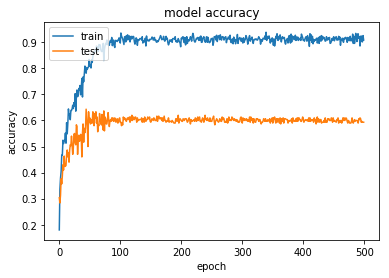

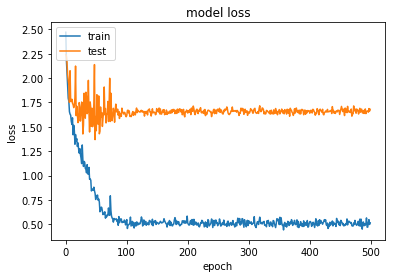

In [8]:
if __name__ == '__main__':
    parser = OptionParser()
    parser.add_option('-d', '--data_path', dest='data_path',
            #default=os.path.join(os.path.dirname(__file__),'data/data.pkl'),
            default=os.path.join(os.getcwd(), 'data/data.pkl'),
            help='path to the data pickle', metavar='DATA_PATH')
    parser.add_option('-m', '--model_path', dest='model_path',
            default=os.path.join(os.getcwd(),
                'models/model.h5'),
            help='path to the output model HDF5 file', metavar='MODEL_PATH')
    options, args = parser.parse_args()

    with open(options.data_path, 'rb') as f:
        data = pickle.load(f)


    #train_model(data, options.model_path)
    model, history=train_model2(data, options.model_path)

    show_summary_stats(history)


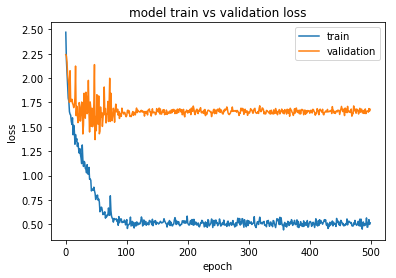

In [9]:
# plot train and validation loss
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [10]:
import tensorflow as tf
from tensorflow.python import debug as tf_debug
import keras

keras.backend.set_session(
    tf_debug.TensorBoardDebugWrapperSession(tf.Session(), "infinity-Inspiron-15-7000-Gaming:6007"))